# Wavelet Transform Analysis

## Introduction

The **wavelet transform** is a powerful mathematical tool for analyzing signals with varying frequency content over time. Unlike the Fourier transform, which decomposes signals into sinusoids of infinite duration, wavelets provide **time-frequency localization**, making them ideal for analyzing non-stationary signals.

## Mathematical Foundation

### Continuous Wavelet Transform (CWT)

The continuous wavelet transform of a signal $f(t)$ is defined as:

$$W_f(a, b) = \frac{1}{\sqrt{|a|}} \int_{-\infty}^{\infty} f(t) \psi^*\left(\frac{t - b}{a}\right) dt$$

where:
- $\psi(t)$ is the **mother wavelet**
- $a$ is the **scale parameter** (controls frequency resolution)
- $b$ is the **translation parameter** (controls time localization)
- $\psi^*$ denotes the complex conjugate

### Admissibility Condition

For a function $\psi(t)$ to be a valid wavelet, it must satisfy the admissibility condition:

$$C_\psi = \int_{-\infty}^{\infty} \frac{|\hat{\psi}(\omega)|^2}{|\omega|} d\omega < \infty$$

where $\hat{\psi}(\omega)$ is the Fourier transform of $\psi(t)$. This implies that $\hat{\psi}(0) = 0$, meaning wavelets have zero mean.

### Common Mother Wavelets

#### Morlet Wavelet

$$\psi(t) = \pi^{-1/4} e^{i\omega_0 t} e^{-t^2/2}$$

The Morlet wavelet is a complex sinusoid modulated by a Gaussian envelope, commonly used with $\omega_0 = 5$ or $6$.

#### Mexican Hat (Ricker) Wavelet

$$\psi(t) = \frac{2}{\sqrt{3\sigma}\pi^{1/4}} \left(1 - \frac{t^2}{\sigma^2}\right) e^{-t^2/(2\sigma^2)}$$

This is the negative normalized second derivative of a Gaussian.

### Scale-Frequency Relationship

The relationship between scale $a$ and pseudo-frequency $f_a$ is:

$$f_a = \frac{f_c}{a \cdot \Delta t}$$

where $f_c$ is the center frequency of the wavelet and $\Delta t$ is the sampling period.

## Objectives

In this notebook, we will:
1. Generate a synthetic signal with time-varying frequency components
2. Implement the continuous wavelet transform using the Morlet wavelet
3. Visualize the scalogram (time-scale representation)
4. Compare with short-time Fourier transform (STFT)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 10

## Signal Generation

We create a **chirp signal** (linearly increasing frequency) combined with a **transient burst** to demonstrate the time-frequency localization capabilities of the wavelet transform.

In [2]:
# Sampling parameters
fs = 1000  # Sampling frequency (Hz)
T = 2.0    # Duration (seconds)
t = np.linspace(0, T, int(T * fs), endpoint=False)
N = len(t)

# Generate chirp signal: frequency sweeps from 10 Hz to 100 Hz
f0, f1 = 10, 100  # Start and end frequencies
chirp_signal = signal.chirp(t, f0, T, f1, method='linear')

# Add a transient burst at t = 1.0 s (50 Hz for 0.1 s)
burst_center = 1.0
burst_width = 0.05
burst_freq = 50
burst_envelope = np.exp(-((t - burst_center) / burst_width) ** 2)
burst_signal = burst_envelope * np.sin(2 * np.pi * burst_freq * t)

# Combined signal with noise
noise = 0.1 * np.random.randn(N)
x = chirp_signal + 1.5 * burst_signal + noise

print(f"Signal length: {N} samples")
print(f"Duration: {T} seconds")
print(f"Sampling frequency: {fs} Hz")

Signal length: 2000 samples
Duration: 2.0 seconds
Sampling frequency: 1000 Hz


## Morlet Wavelet Implementation

We implement the Morlet wavelet and the continuous wavelet transform.

In [3]:
def morlet_wavelet(t, omega0=6.0):
    """
    Generate a Morlet wavelet.
    
    Parameters:
    -----------
    t : array-like
        Time array
    omega0 : float
        Central frequency parameter (default: 6.0)
    
    Returns:
    --------
    psi : complex array
        Morlet wavelet values
    """
    return np.pi**(-0.25) * np.exp(1j * omega0 * t) * np.exp(-t**2 / 2)


def cwt_morlet(signal, scales, dt, omega0=6.0):
    """
    Compute the Continuous Wavelet Transform using Morlet wavelet.
    
    Parameters:
    -----------
    signal : array-like
        Input signal
    scales : array-like
        Scale values for the transform
    dt : float
        Sampling period
    omega0 : float
        Morlet wavelet central frequency
    
    Returns:
    --------
    coefficients : 2D complex array
        CWT coefficients (scales x time)
    frequencies : array
        Pseudo-frequencies corresponding to scales
    """
    N = len(signal)
    coefficients = np.zeros((len(scales), N), dtype=complex)
    
    for i, scale in enumerate(scales):
        # Create scaled and normalized wavelet
        # Time array centered at zero
        wavelet_length = min(10 * int(scale / dt), N)
        if wavelet_length % 2 == 0:
            wavelet_length += 1

        half_len = wavelet_length // 2
        t_wavelet = np.arange(-half_len, half_len + 1) * dt
        wavelet = morlet_wavelet(t_wavelet / scale, omega0) / np.sqrt(scale)

        # Convolve signal with wavelet
        conv_result = np.convolve(signal, np.conj(wavelet[::-1]), mode='same')
        coefficients[i, :] = conv_result[:N] * dt
    
    # Convert scales to pseudo-frequencies
    frequencies = omega0 / (2 * np.pi * scales * dt)
    
    return coefficients, frequencies


# Define scales (logarithmically spaced for better frequency resolution)
num_scales = 100
scales = np.logspace(np.log10(0.01), np.log10(0.5), num_scales)

# Compute CWT
dt = 1 / fs
cwt_coeffs, freqs = cwt_morlet(x, scales, dt)

# Power spectrum (scalogram)
power = np.abs(cwt_coeffs) ** 2

print(f"Scales range: {scales[0]:.4f} to {scales[-1]:.4f}")
print(f"Frequency range: {freqs[-1]:.1f} Hz to {freqs[0]:.1f} Hz")

Scales range: 0.0100 to 0.5000
Frequency range: 1909.9 Hz to 95493.0 Hz


## Visualization: Scalogram and Comparison

We now visualize the results including:
1. The original signal
2. The wavelet scalogram
3. Comparison with STFT spectrogram

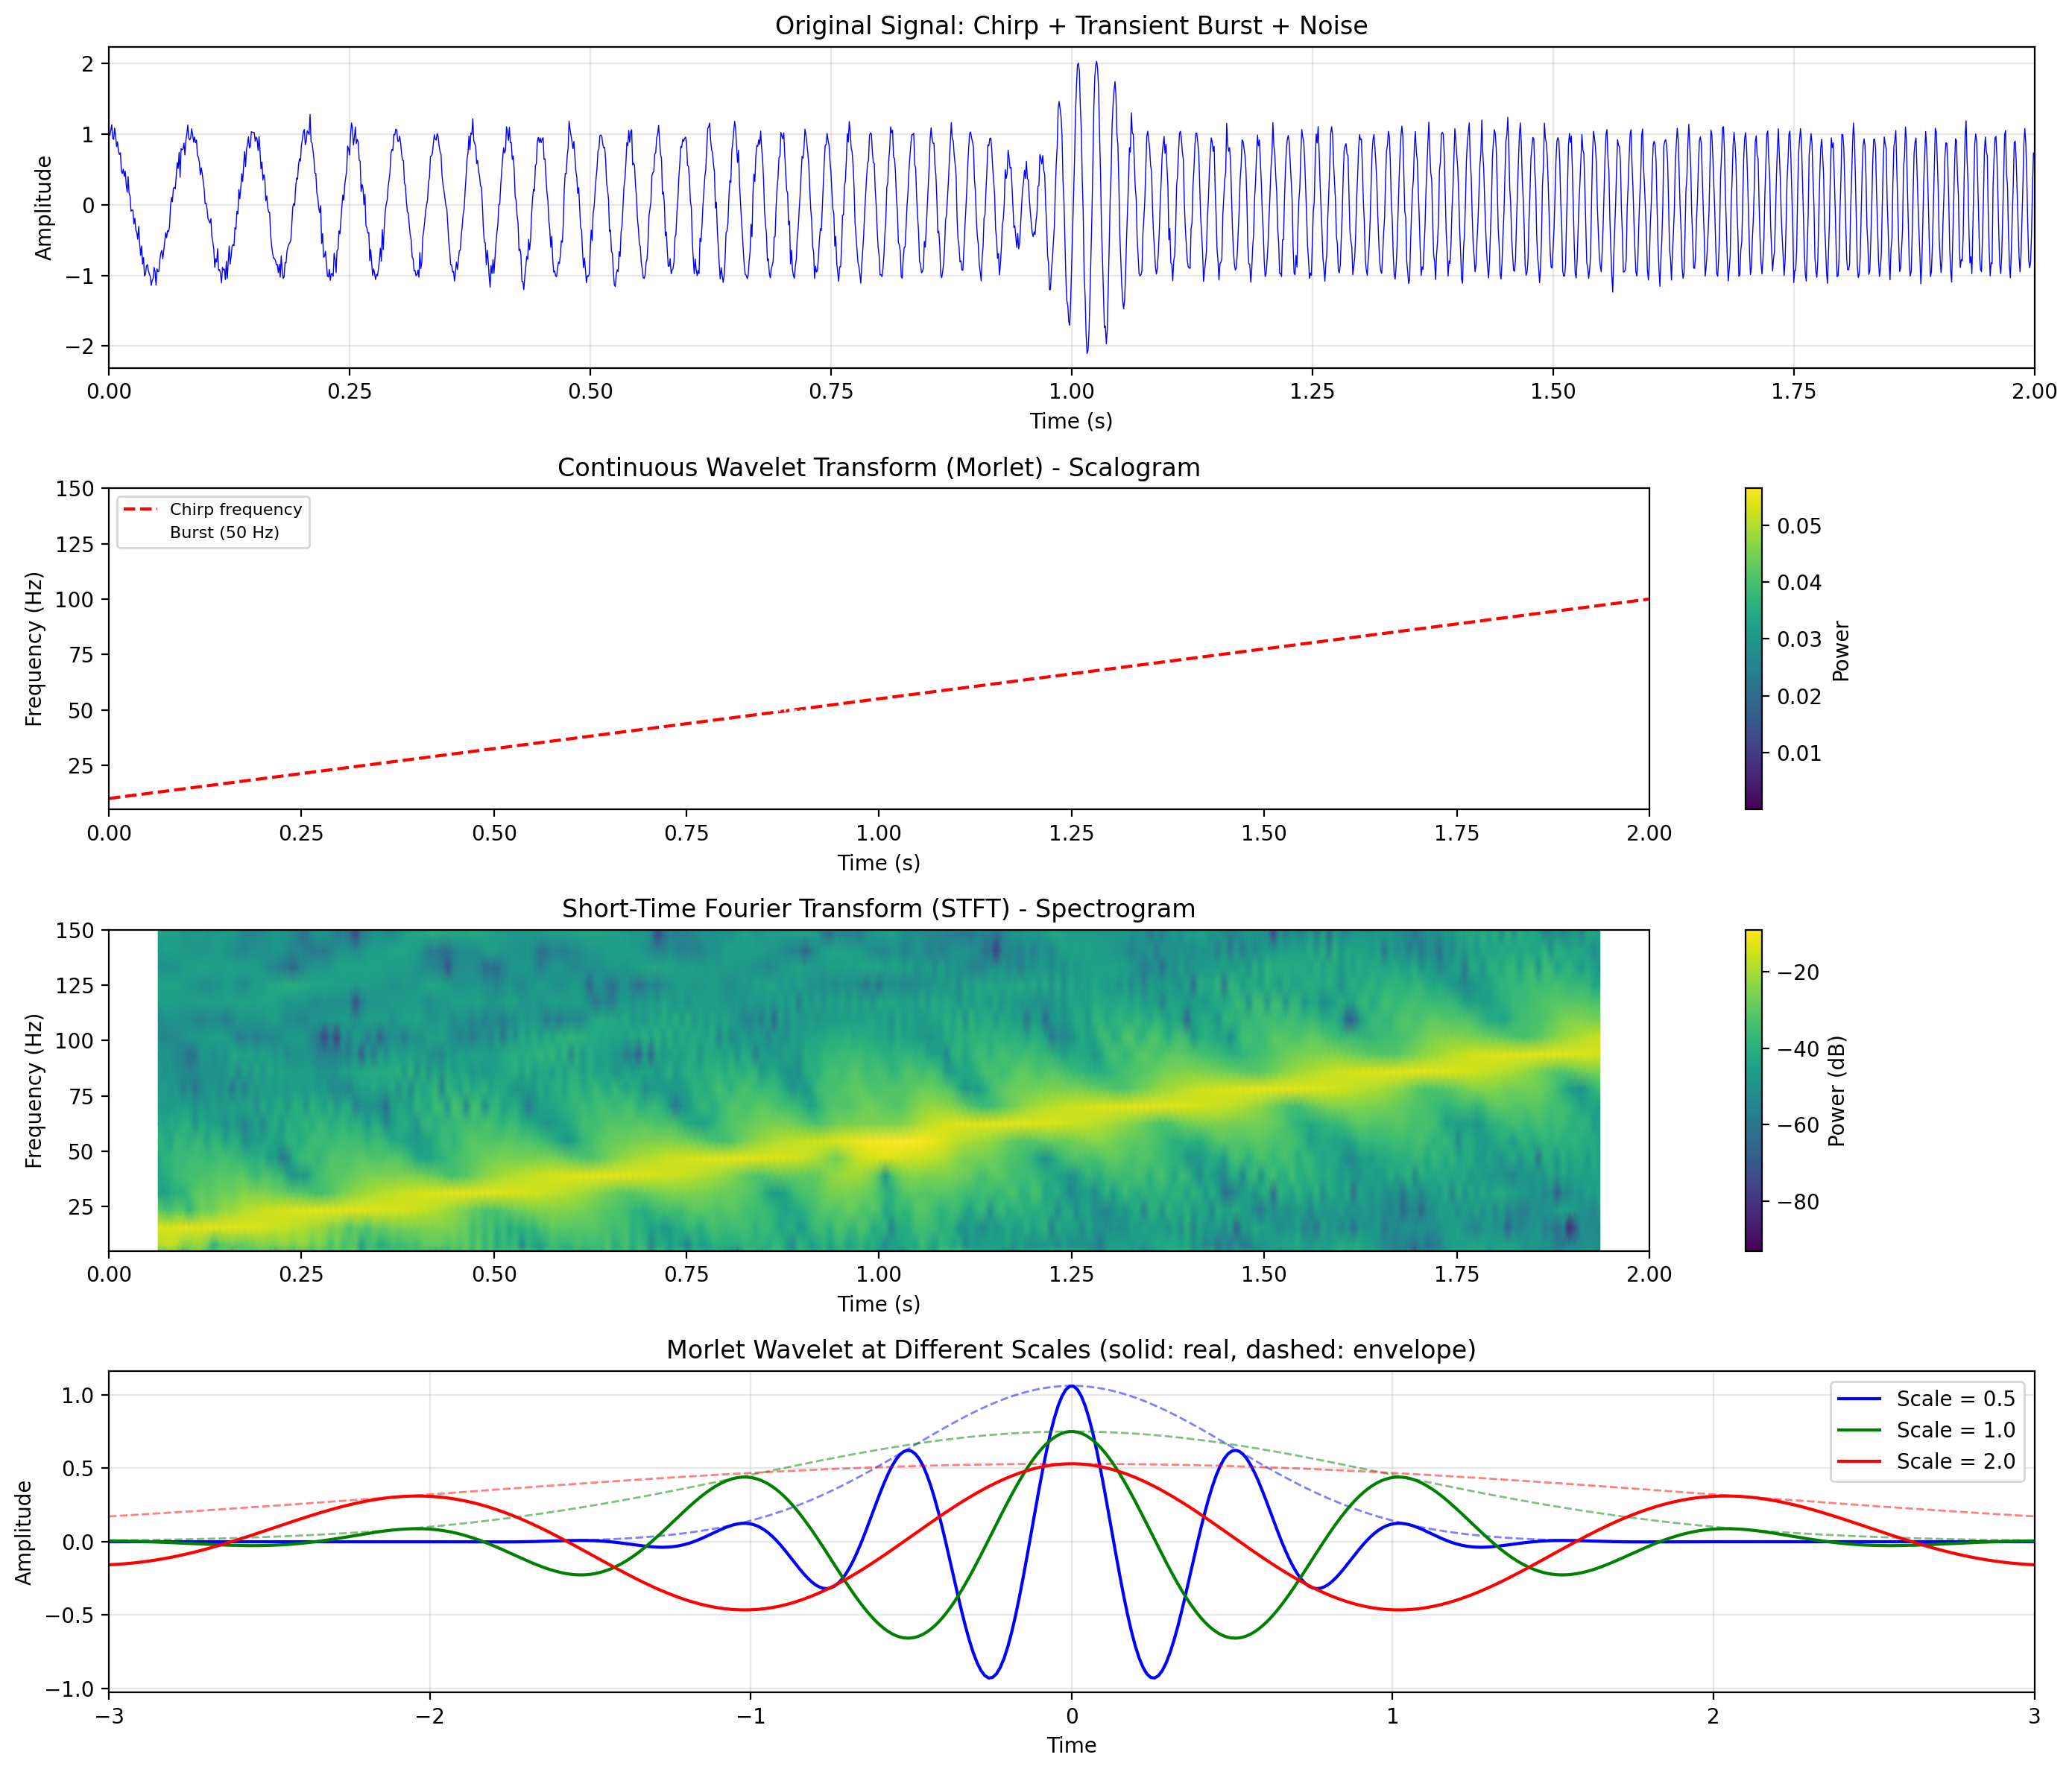


Plot saved to 'plot.png'


In [4]:
# Compute STFT for comparison
nperseg = 128
noverlap = 120
f_stft, t_stft, Sxx = signal.spectrogram(x, fs, nperseg=nperseg, noverlap=noverlap)

# Create comprehensive visualization
fig = plt.figure(figsize=(14, 12))

# Plot 1: Original signal
ax1 = plt.subplot(4, 1, 1)
ax1.plot(t, x, 'b-', linewidth=0.5)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Original Signal: Chirp + Transient Burst + Noise')
ax1.set_xlim([0, T])
ax1.grid(True, alpha=0.3)

# Plot 2: Wavelet Scalogram
ax2 = plt.subplot(4, 1, 2)
im2 = ax2.pcolormesh(t, freqs, power, shading='gouraud', cmap='viridis')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Continuous Wavelet Transform (Morlet) - Scalogram')
ax2.set_ylim([5, 150])
ax2.set_xlim([0, T])
cbar2 = plt.colorbar(im2, ax=ax2, label='Power')

# Overlay theoretical chirp frequency
chirp_freq_theoretical = f0 + (f1 - f0) * t / T
ax2.plot(t, chirp_freq_theoretical, 'r--', linewidth=1.5, label='Chirp frequency')
ax2.axhline(y=burst_freq, color='w', linestyle=':', linewidth=1, label=f'Burst ({burst_freq} Hz)')
ax2.legend(loc='upper left', fontsize=8)

# Plot 3: STFT Spectrogram for comparison
ax3 = plt.subplot(4, 1, 3)
im3 = ax3.pcolormesh(t_stft, f_stft, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Short-Time Fourier Transform (STFT) - Spectrogram')
ax3.set_ylim([5, 150])
ax3.set_xlim([0, T])
cbar3 = plt.colorbar(im3, ax=ax3, label='Power (dB)')

# Plot 4: Morlet wavelet at different scales
ax4 = plt.subplot(4, 1, 4)
t_demo = np.linspace(-3, 3, 500)
scales_demo = [0.5, 1.0, 2.0]
colors = ['blue', 'green', 'red']

for scale, color in zip(scales_demo, colors):
    psi = morlet_wavelet(t_demo / scale) / np.sqrt(scale)
    ax4.plot(t_demo, np.real(psi), color=color, linewidth=1.5, 
             label=f'Scale = {scale}')
    ax4.plot(t_demo, np.abs(psi), color=color, linewidth=1, linestyle='--', alpha=0.5)

ax4.set_xlabel('Time')
ax4.set_ylabel('Amplitude')
ax4.set_title('Morlet Wavelet at Different Scales (solid: real, dashed: envelope)')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([-3, 3])

plt.tight_layout()
plt.savefig('wavelet_transform_analysis_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Interpretation

### Key Observations

1. **Time-Frequency Localization**: The wavelet scalogram clearly shows the linear frequency sweep of the chirp signal, with the instantaneous frequency increasing from 10 Hz to 100 Hz over 2 seconds.

2. **Transient Detection**: The transient burst at $t = 1.0$ s is well-localized in both time and frequency (50 Hz), demonstrating the wavelet transform's ability to capture localized events.

3. **Resolution Trade-off**: 
   - At **low frequencies** (large scales): Good frequency resolution but poor time resolution
   - At **high frequencies** (small scales): Good time resolution but poor frequency resolution
   
   This is a manifestation of the **Heisenberg uncertainty principle**:
   $$\Delta t \cdot \Delta f \geq \frac{1}{4\pi}$$

4. **Comparison with STFT**: The STFT has fixed time-frequency resolution (determined by window size), while the CWT provides adaptive multi-resolution analysis.

### Advantages of Wavelet Transform

- Multi-resolution analysis adapts to signal characteristics
- Better suited for non-stationary signals
- Efficient representation of transient phenomena
- Natural framework for signal compression and denoising

In [5]:
# Quantitative analysis: Energy distribution across scales
energy_per_scale = np.sum(power, axis=1)
total_energy = np.sum(energy_per_scale)
normalized_energy = energy_per_scale / total_energy

# Find dominant frequencies
peak_indices = np.argsort(normalized_energy)[-5:]

print("Energy Distribution Analysis")
print("=" * 40)
print(f"\nTotal signal energy in CWT: {total_energy:.2f}")
print("\nTop 5 dominant frequency components:")
for idx in reversed(peak_indices):
    print(f"  {freqs[idx]:.1f} Hz: {100*normalized_energy[idx]:.1f}% of energy")

Energy Distribution Analysis

Total signal energy in CWT: 319.93

Top 5 dominant frequency components:
  52790.0 Hz: 2.3% of energy
  50744.7 Hz: 2.3% of energy
  54917.8 Hz: 2.3% of energy
  48778.6 Hz: 2.3% of energy
  46888.7 Hz: 2.2% of energy


## Conclusion

The wavelet transform provides a powerful framework for analyzing signals with time-varying spectral content. The Morlet wavelet, with its optimal time-frequency localization, is particularly well-suited for detecting both gradual frequency changes (chirps) and transient events (bursts).

Key mathematical insights:
- The CWT decomposes signals using dilated and translated versions of a mother wavelet
- Scale inversely relates to frequency: $f \propto 1/a$
- The uncertainty principle governs the fundamental resolution trade-off

Applications include:
- Seismic signal analysis
- Biomedical signal processing (ECG, EEG)
- Image compression (JPEG 2000)
- Financial time series analysis